# **AutoEncoder :**

1.Autoencoder is a type of neural network that can be used to learn a compressed representation of raw data.

2.An autoencoder is composed of an encoder and a decoder sub-models. The encoder compresses the input and the decoder attempts to recreate the input from the compressed version provided by the encoder. After training, the encoder model is saved and the decoder is discarded.
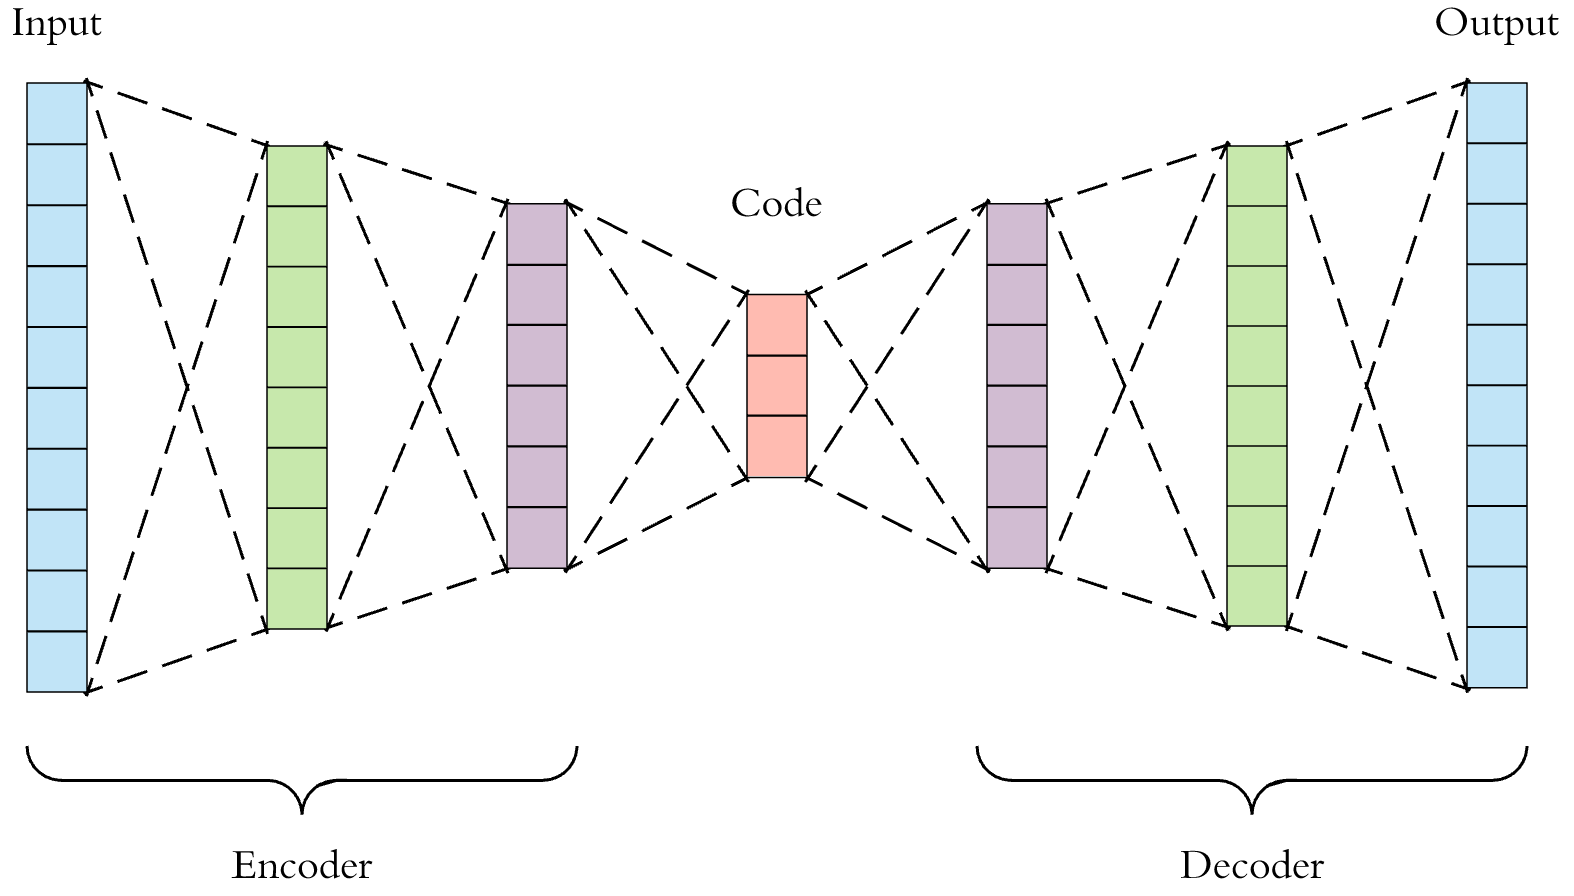

3.The encoder can then be used as a data preparation technique to perform feature extraction on raw data that can be used to train a different machine learning model.

In [1]:
#Importing the Libraries
from sklearn.datasets import make_classification
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model

In [2]:
# define dataset
X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)
# summarize the dataset
print(X.shape, y.shape)

(1000, 100) (1000,)


In [3]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

In [4]:
# AutoEncoder Model Preparation
n_inputs = X.shape[1]
# define encoder
input_data_shape= Input(shape=(n_inputs,))
# encoder level 1
encoder= Dense(n_inputs*2)(input_data_shape)
encoder = BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# encoder level 2
encoder= Dense(n_inputs)(encoder)
encoder= BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# bottleneck
n_bottleneck = round(float(n_inputs) / 2.0)
bottleneck = Dense(n_bottleneck)(encoder)
# define decoder, level 1
decoder = Dense(n_inputs)(bottleneck)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
# decoder level 2
decoder = Dense(n_inputs*2)(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)


In [5]:
# output layer
output = Dense(n_inputs, activation='linear')(decoder)
# define autoencoder model
model = Model(inputs=input_data_shape, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 200)               20200     
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100)               0     

In [7]:
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=2, validation_data=(X_test,y_test))

Epoch 1/50
42/42 - 3s - loss: 0.3531 - val_loss: 0.3408
Epoch 2/50
42/42 - 0s - loss: 0.1302 - val_loss: 0.2678
Epoch 3/50
42/42 - 0s - loss: 0.1189 - val_loss: 0.2090
Epoch 4/50
42/42 - 0s - loss: 0.0903 - val_loss: 0.1760
Epoch 5/50
42/42 - 0s - loss: 0.0840 - val_loss: 0.1277
Epoch 6/50
42/42 - 0s - loss: 0.0779 - val_loss: 0.0952
Epoch 7/50
42/42 - 0s - loss: 0.0766 - val_loss: 0.0906
Epoch 8/50
42/42 - 0s - loss: 0.0832 - val_loss: 0.0847
Epoch 9/50
42/42 - 0s - loss: 0.0627 - val_loss: 0.0608
Epoch 10/50
42/42 - 0s - loss: 0.0679 - val_loss: 0.0730
Epoch 11/50
42/42 - 0s - loss: 0.0735 - val_loss: 0.0571
Epoch 12/50
42/42 - 0s - loss: 0.0719 - val_loss: 0.0622
Epoch 13/50
42/42 - 0s - loss: 0.0633 - val_loss: 0.0806
Epoch 14/50
42/42 - 0s - loss: 0.0631 - val_loss: 0.0939
Epoch 15/50
42/42 - 0s - loss: 0.0603 - val_loss: 0.0548
Epoch 16/50
42/42 - 0s - loss: 0.0546 - val_loss: 0.0545
Epoch 17/50
42/42 - 0s - loss: 0.0511 - val_loss: 0.0491
Epoch 18/50
42/42 - 0s - loss: 0.0566 - 

In [8]:
# define an encoder model (without the decoder)
encoder = Model(inputs=input_data_shape, outputs=bottleneck)
# save the encoder to file
encoder.save('encoder.h5')

In [9]:
#Building a Base Model to compare the performance after compressing the data using Encoder model.

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
# define model
model = LogisticRegression()
# fit model on training set
model.fit(X_train, y_train)
# make prediction on test set
yhat = model.predict(X_test)
# calculate accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

0.8939393939393939


Now,We can then use the encoder to transform the raw input data (e.g. 100 columns) into bottleneck vectors (e.g. 50 element vectors).

In [10]:
#Compressing the input data using Encoder Model and fitting it on the Logistic Regression model.
# load the model from file
encoder = load_model('encoder.h5')

# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)
# define the model
model = LogisticRegression(max_iter=1000)
# fit the model on the training set
model.fit(X_train_encode, y_train)
# make predictions on the test set
yhat = model.predict(X_test_encode)
# calculate classification accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

0.9484848484848485


# **Conclusion:**

This is a better classification accuracy than the same model evaluated on the raw dataset, suggesting that the encoding is helpful for our chosen model and test harness.